In [1]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd
import time
from scipy import stats
import heapq
import warnings

In [30]:
# M/M/1 (M/M/n) queueing system
def generate_interarrival(mu,n,rho):
    return random.expovariate(mu*n*rho)


def source(env, n, rho, mu, servers, que_arr):
    """Source generates customers randomly based on exponential distribution"""
    i = 0
    while True:
        i += 1
        c = customer(env, i, servers, mu, que_arr)
        env.process(c)
        t = random.expovariate(mu*n*rho)
        yield env.timeout(t)   

total_waiting_time = []

#def customer(env, customer, servers, mu, que_arr):
  #  """This generator function models the behavior of a customer in the queue."""
  #  time_of_arrival = env.now
  #  que_arr.append((env.now, len(servers.queue)))
  #  with servers.request() as req:    
  #      #print(env.now, 'customer {} arrives'.format(customer))
  #      yield req
  #      time_of_handling = random.expovariate(mu)
  #      #print(env.now, 'customer {} is being served'.format(customer))
  #      yield env.timeout(time_of_handling)
  #      waiting_time = env.now
  #      #print(env.now, 'customer {} departs'.format(customer))
  #      total_waiting_time.append((env.now, waiting_time-time_of_arrival))

def customer(env, customer, servers, mu, que_arr):
    """This generator function models the behavior of a customer in the queue."""
    time_of_handling = random.expovariate(mu)
    que_arr.append((env.now, len(servers.queue)))
    with servers.request() as req:
        #print(env.now, 'customer {} arrives'.format(customer))
        time_of_arrival = env.now    
        yield req
        #print(env.now, 'customer {} is being served'.format(customer))
        waiting_time = env.now
        yield env.timeout(time_of_handling)
        #print(env.now, 'customer {} departs'.format(customer))
        total_waiting_time.append((env.now, waiting_time-time_of_arrival))

### Setup and start the simulation

# Initial values            
mu = 1  # Parameter mu
rho = 0.9 #[0.7,0.85,0.9,0.95,0.99] # Parameter rho (varying for values close to 1)
n = 2 # Number of servers, in our case 1, 2 and 4

env = simpy.Environment()
que_arr =[]
# Start processes and run
servers = simpy.Resource(env, capacity=n)
env.process(source(env, n, rho, mu, servers, que_arr))
env.run(until=200)
print(f"Total customers served: {len(total_waiting_time)}")


Total customers served: 346


In [40]:
# Defining function for simulating M/M/n queue system

# Setup and start the simulation
def sim_run(n,rho,mu,sim_duration):
    env = simpy.Environment()
    # Start processes and run
    que_arr =[]
    servers = simpy.Resource(env, capacity=n)
    env.process(source(env, n, rho, mu, servers, que_arr))
    env.run(until=sim_duration)
    return total_waiting_time, que_arr
    
mean_queue_lengths = pd.DataFrame()
rho_vals = [0.85,0.9,0.95,0.99]
serv = [1, 2, 4]
sim_time = 20000
mu = 1.0         
all_results = []
second_data_que = []
mean_vaiting = []
all_results_mean = []
z_score = 1.96
mean_std_ci_queue_lengths = pd.DataFrame()
mean_std_ci_waiting_time = pd.DataFrame()
waiting_time_general_stat = pd.DataFrame()
simulations = 5

# The loops to go through numb. of servers and p value
for server in serv:
    for p_value in rho_vals:
        #I defne all arrays and vars that are reused for each params.
        second_data_que = []
        mean_vaiting = []
        mean_waiting_data_for_statistics = []
        std_waiting_data_for_statistics = []
        customers_srvd_stat = []
        queue_stat = []
        maxim = -np.inf
        minim = np.inf
        maxim_que = -np.inf
        minim_que = np.inf
        maxim_customers_served = -np.inf
        minim_customers_served = np.inf
        #Run simulations
        for run in range(simulations):
            #Run and extract data from simulation 
            waiting_data, queue_data = sim_run(server,p_value,mu,sim_time)
            #Here I calculate everything for dataframe that will calculate overall atatistics for n simulations
            f = lambda a: a[1]
            waiting_data_true = list(map(f, waiting_data))
            queue_data_true = list(map(f, queue_data))
            mean_queue_cur_sim = np.mean(queue_data_true)
            mean_waiting_cur_sim = np.mean(waiting_data_true)
            max_waiting = np.max(waiting_data_true)
            maxim = max(max_waiting, maxim)
            min_waiting = np.min(waiting_data_true)
            minim = min(min_waiting, minim)
            max_que = np.max(queue_data_true)
            maxim_que = max(max_que, maxim_que)
            min_que = np.min(queue_data_true)
            minim_que = min(min_que, minim_que)
            customer_served = len(waiting_data_true)
            maxim_customers_served = max(customer_served, maxim_customers_served)
            minim_customers_served = min(customer_served, minim_customers_served)
            std_within_sim_waiting = np.std(waiting_data_true)
            mean_waiting_data_for_statistics.append(mean_waiting_cur_sim)
            std_waiting_data_for_statistics.append(std_within_sim_waiting)
            queue_stat.append(mean_queue_cur_sim)
            customers_srvd_stat.append(customer_served)
            # Here I create dataframes for interday statistics for n sims
            df_queue = pd.DataFrame(queue_data, columns=['Time', 'Queue_Length'])
            df_queue['Time'] = df_queue['Time'].round().astype(int) // 100
            df_second_mean = df_queue.groupby('Time').mean()
            second_data_que.append(df_second_mean)
            df_waiting = pd.DataFrame(waiting_data, columns=['Time', 'Waiting_time'])
            df_waiting['Time'] = df_waiting['Time'].round().astype(int) // 100
            df_waiting_mean = df_waiting.groupby('Time').mean()
            mean_vaiting.append(df_waiting_mean)
        #All calculations related to daily dataframes. Basically two dtatframes with mean value for every 100 days 
        for second in range(0, int(sim_time/100)):
            interval_data = [pd.Series(df.loc[second]['Queue_Length']) if second in df.index else pd.Series([0]) for df in second_data_que]
            concatenated_data = pd.concat(interval_data, ignore_index=True)
            mean_length = concatenated_data.mean()
            std_dev = concatenated_data.std()
            margin_of_error = z_score * (std_dev / np.sqrt(len(concatenated_data)))
            lower_bound = mean_length - margin_of_error
            upper_bound = mean_length + margin_of_error
            mean_std_ci_queue_lengths = mean_std_ci_queue_lengths._append({
                'Server_Count': server, 
                'P_Value': p_value, 
                'Time_Second': (second+1)*100,
                'Mean_Queue_Length': mean_length,
                'Std_Dev_Queue_Length': std_dev,
                'CI_Lower_Bound': lower_bound,
                'CI_Upper_Bound': upper_bound
            }, ignore_index=True)
            interval_data_waiting = [pd.Series(df.loc[second]['Waiting_time']) if second in df.index else pd.Series() for df in mean_vaiting]
            concatenated_data_waiting = pd.concat(interval_data_waiting, ignore_index=True)
            mean_length_waiting = concatenated_data_waiting.mean()
            std_dev_waiting = concatenated_data_waiting.std()
            confidence_waiting_time = z_score * (std_dev_waiting / np.sqrt(len(concatenated_data_waiting)))
            lower_bound_waiting = mean_length_waiting - confidence_waiting_time
            upper_bound_waiting = mean_length_waiting + confidence_waiting_time
            mean_std_ci_waiting_time = mean_std_ci_waiting_time._append({
                'Server_Count': server, 
                'P_Value': p_value, 
                'Time_Second': (second+1)*100,
                'Mean_Waiting_time': mean_length_waiting,
                'Std_Dev_Waiting_time': std_dev_waiting,
                'CI_Lower_Bound': lower_bound_waiting,
                'CI_Upper_Bound': upper_bound_waiting
            }, ignore_index=True)
        # All calculations for overall statistics over 100 simulations
        whole_sim_mean = np.mean(mean_waiting_data_for_statistics) 
        whole_sim_within_std = np.mean(std_waiting_data_for_statistics)
        std_whole_sim = np.std(mean_waiting_data_for_statistics)  
        std_fr_std_whole_sim = np.std(std_waiting_data_for_statistics)  
        confidence_waiting_time_whole = z_score * (std_whole_sim / np.sqrt(len(mean_waiting_data_for_statistics)))
        lower_bound_waiting_whole = whole_sim_mean - confidence_waiting_time_whole
        upper_bound_waiting_whole = whole_sim_mean + confidence_waiting_time_whole   
        confidence_waiting_std_within = z_score * (std_fr_std_whole_sim / np.sqrt(len(std_waiting_data_for_statistics)))
        lower_bound_waiting_std_within = whole_sim_within_std - confidence_waiting_std_within
        upper_bound_waiting_std_within = whole_sim_within_std + confidence_waiting_std_within 
        customers_served_mean = np.mean(customers_srvd_stat)
        customers_served_std = np.std(customers_srvd_stat)
        confidence_customers_served = z_score * (customers_served_std / np.sqrt(len(customers_srvd_stat)))
        lower_bound_customers_served = customers_served_mean - confidence_customers_served
        upper_bound_customers_served = customers_served_mean + confidence_customers_served 
        mean_que = np.mean(queue_stat)
        std_que = np.mean(queue_stat)
        confidence_que = z_score * (std_que / np.sqrt(len(queue_stat)))
        lower_bound_que = mean_que - confidence_que
        upper_bound_que = mean_que + confidence_que 
        waiting_time_general_stat = waiting_time_general_stat._append({
                'Server_Count': server, 
                'P_Value': p_value, 
                'Mean_Waiting_time': whole_sim_mean,
                'Mean_Within_Std_of_Waiting_time': whole_sim_within_std,
                'Customers_Served': customers_served_mean,
                'Mean_queue': mean_que,
                'Std_within_Waiting_time': std_fr_std_whole_sim,
                'Std_Dev_Waiting_time': std_whole_sim,
                'Std_Dev_Customers_served': customers_served_std,
                'Std_Dev_Queue': std_que,
                'CI_Lower_Bound_Mean': lower_bound_waiting_whole,
                'CI_Upper_Bound_Mean': upper_bound_waiting_whole,
                'CI_Lower_Bound_Std': lower_bound_waiting_std_within,
                'CI_Upper_Bound_Std': upper_bound_waiting_std_within, 
                'CI_Lower_Bound_Customers_Served': lower_bound_customers_served,
                'CI_Upper_Bound_Customers_Served': upper_bound_customers_served, 
                'CI_Lower_Bound_Queue': lower_bound_que,
                'CI_Upper_Bound_Queue': upper_bound_que, 
                'Min_waiting_time': minim,
                'Max_waiting_time': maxim,
                'Min_queue': minim_que,
                'Max_queue': maxim_que,
                'Min_customers_served': minim_customers_served,
                'Max_customers_served': maxim_customers_served
                }, ignore_index=True)

In [41]:
mean_std_ci_queue_lengths_df = pd.DataFrame(mean_std_ci_queue_lengths )
mean_std_ci_waiting_time_df = pd.DataFrame(mean_std_ci_waiting_time)
waiting_time_general_stat_df = pd.DataFrame(waiting_time_general_stat)

In [42]:
display(waiting_time_general_stat_df)

,Server_Count,P_Value,Mean_Waiting_time,Mean_Within_Std_of_Waiting_time,Customers_Served,Mean_queue,Std_within_Waiting_time,Std_Dev_Waiting_time,Std_Dev_Customers_served,Std_Dev_Queue,...,CI_Lower_Bound_Customers_Served,CI_Upper_Bound_Customers_Served,CI_Lower_Bound_Queue,CI_Upper_Bound_Queue,Min_waiting_time,Max_waiting_time,Min_queue,Max_queue,Min_customers_served,Max_customers_served
0,1.0,0.85,14.720868,31.651720,1166131.6,5.057784,0.284481,0.187095,24024.355913,5.057784,...,1.145073e+06,1.187190e+06,0.624441,9.491127,0.0,229.858098,0.0,57.0,1132157.0,1200040.0
1,1.0,0.90,14.261246,30.675015,1254174.0,9.194071,0.259097,0.083965,25451.392536,9.194071,...,1.231865e+06,1.276483e+06,1.135112,17.253030,0.0,229.858098,0.0,85.0,1218136.0,1290208.0
2,1.0,0.95,14.229835,29.829618,1347069.6,14.984003,0.221947,0.029958,26764.602105,14.984003,...,1.323609e+06,1.370530e+06,1.849945,28.118061,0.0,229.858098,0.0,87.0,1309155.0,1384884.0
3,1.0,0.99,15.644084,30.666599,1444356.8,51.583649,0.738701,0.734089,27933.150846,51.583649,...,1.419872e+06,1.468841e+06,6.368587,96.798711,0.0,229.858098,0.0,202.0,1404722.0,1483763.0
4,2.0,0.85,15.892731,31.084308,1585639.8,4.824052,0.382133,0.394723,48070.176190,4.824052,...,1.543504e+06,1.627775e+06,0.595584,9.052520,0.0,229.858098,0.0,65.0,1517654.0,1653585.0
5,2.0,0.90,14.689282,29.750177,1761353.6,7.739084,0.364145,0.304801,50711.475327,7.739084,...,1.716903e+06,1.805804e+06,0.955478,14.522690,0.0,229.858098,0.0,78.0,1689649.0,1833100.0
6,2.0,0.95,13.882666,28.503175,1946285.8,14.865095,0.335453,0.145232,53756.204242,14.865095,...,1.899166e+06,1.993405e+06,1.835265,27.894925,0.0,229.858098,0.0,120.0,1870384.0,2022292.0
7,2.0,0.99,14.910459,28.614079,2141220.4,81.298546,0.637033,0.810437,56037.829757,81.298546,...,2.092101e+06,2.190340e+06,10.037228,152.559863,0.0,229.858098,0.0,358.0,2061836.0,2220358.0
8,4.0,0.85,14.884987,28.745371,2423038.6,3.610462,0.436112,0.546538,95787.685621,3.610462,...,2.339077e+06,2.507000e+06,0.445753,6.775171,0.0,229.858098,0.0,46.0,2287818.0,2558649.0
9,4.0,0.90,13.205457,27.229440,2775074.6,7.467923,0.412703,0.409881,102092.471775,7.467923,...,2.685587e+06,2.864563e+06,0.922000,14.013845,0.0,229.858098,0.0,95.0,2630535.0,2919601.0


C:\Users\user\AppData\Local\Temp\ipykernel_22860\2377592342.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filted_set_f2 = filted_set[mask_p_value]


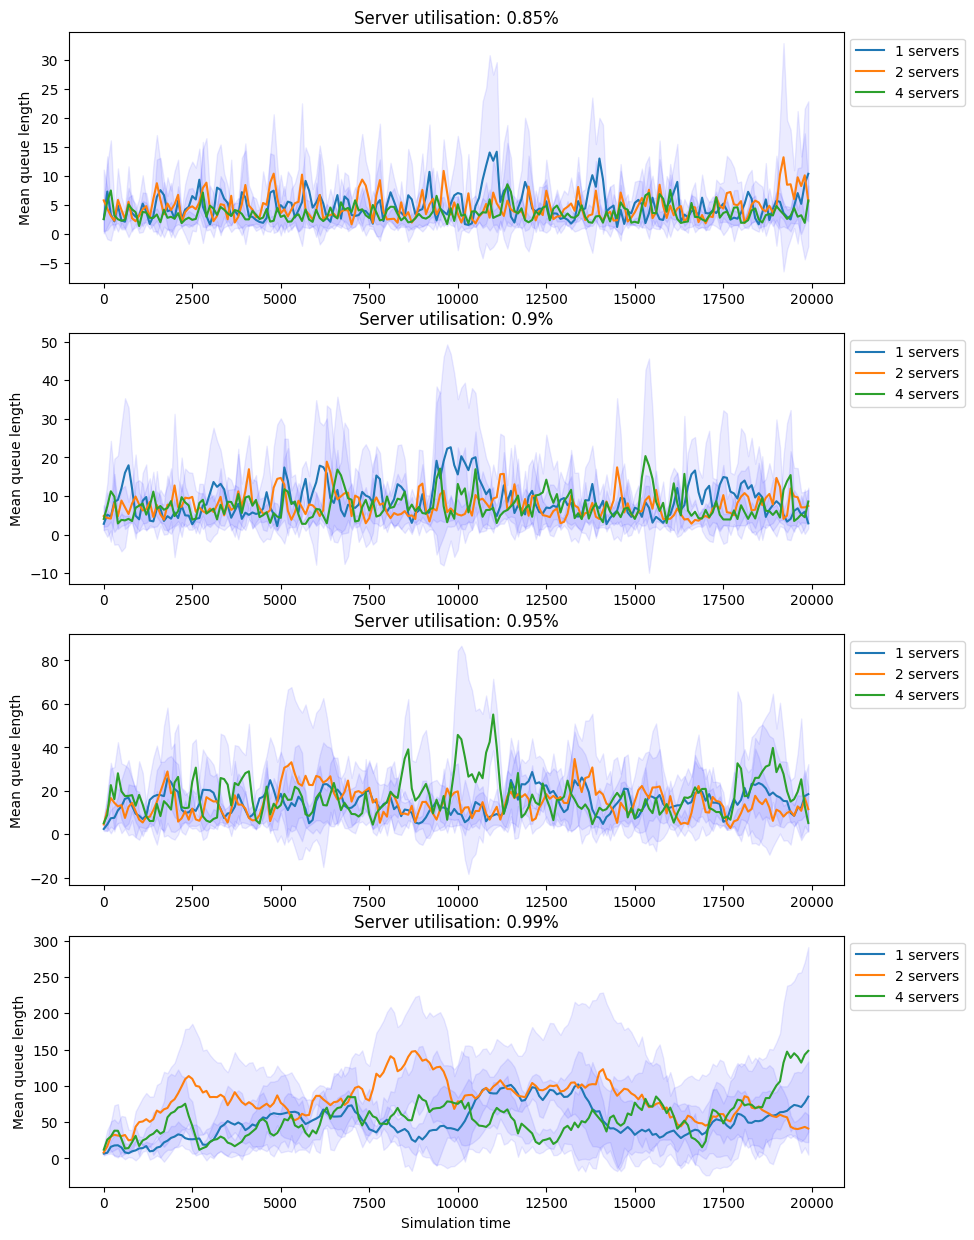

In [43]:
def extract_res_for_plt(dataframe, numb_serv, p_val):
    mask_severs = dataframe["Server_Count"] == numb_serv
    mask_p_value =  dataframe["P_Value"] == p_val
    filted_set = dataframe[mask_severs]
    filted_set_f2 = filted_set[mask_p_value]
    filtered_datasetos = filted_set_f2["Mean_Queue_Length"]
    filtered_datasetos_cl_l = filted_set_f2["CI_Lower_Bound"]
    filtered_datasetos_cl_u = filted_set_f2["CI_Upper_Bound"]
    return filtered_datasetos, filtered_datasetos_cl_l, filtered_datasetos_cl_u


serv = [1, 2, 4]
p = [0.85, 0.9, 0.95, 0.99]


ma = []
for x in range(0, 20000, 100):
    ma.append(x)

fig, axs = plt.subplots(4, 1, figsize=(10, 15))  

for pp in serv:
    y, low, up = extract_res_for_plt(mean_std_ci_queue_lengths, pp, 0.85)
    axs[0].plot(ma, y, label=f"{pp} servers")
    axs[0].fill_between(ma, low, up, color='b', alpha=0.08)
    axs[0].set_ylabel("Mean queue length")
    axs[0].set_title("Server utilisation: 0.85%")
    axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

for pp in serv:
    y, low, up = extract_res_for_plt(mean_std_ci_queue_lengths, pp, 0.9)
    axs[1].plot(ma, y, label=f"{pp} servers")
    axs[1].fill_between(ma, low, up, color='b', alpha=0.08)
    axs[1].set_ylabel("Mean queue length")
    axs[1].set_title("Server utilisation: 0.9%")
    axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

for pp in serv:
    y, low, up = extract_res_for_plt(mean_std_ci_queue_lengths, pp, 0.95)
    axs[2].plot(ma, y, label=f"{pp} servers")
    axs[2].fill_between(ma, low, up, color='b', alpha=0.08)
    axs[2].set_ylabel("Mean queue length")
    axs[2].set_title("Server utilisation: 0.95%")
    axs[2].legend(loc='upper left', bbox_to_anchor=(1, 1))


for pp in serv:
    y, low, up = extract_res_for_plt(mean_std_ci_queue_lengths, pp, 0.99)
    axs[3].plot(ma, y, label=f"{pp} servers")
    axs[3].fill_between(ma, low, up, color='b', alpha=0.08)
    axs[3].set_ylabel("Mean queue length")
    axs[3].set_xlabel("Simulation time")
    axs[3].set_title("Server utilisation: 0.99%")
    axs[3].legend(loc='upper left', bbox_to_anchor=(1, 1))



In [44]:
mean_std_ci_queue_lengths

,Server_Count,P_Value,Time_Second,Mean_Queue_Length,Std_Dev_Queue_Length,CI_Lower_Bound,CI_Upper_Bound
0,1.0,0.85,100.0,2.559919,2.794694,0.110262,5.009577
1,1.0,0.85,200.0,7.310947,6.928490,1.237858,13.384037
2,1.0,0.85,300.0,3.343225,0.945203,2.514718,4.171732
3,1.0,0.85,400.0,2.167107,1.705753,0.671948,3.662266
4,1.0,0.85,500.0,4.914861,1.526108,3.577168,6.252553
...,...,...,...,...,...,...,...
2395,4.0,0.99,19600.0,145.011502,113.892209,45.180579,244.842424
2396,4.0,0.99,19700.0,140.256961,131.203837,25.251726,255.262195
2397,4.0,0.99,19800.0,132.108588,142.142454,7.515234,256.701942
2398,4.0,0.99,19900.0,143.065328,145.846083,15.225600,270.905056


C:\Users\user\AppData\Local\Temp\ipykernel_22860\1213132079.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filted_set_f2 = filted_set[mask_p_value]


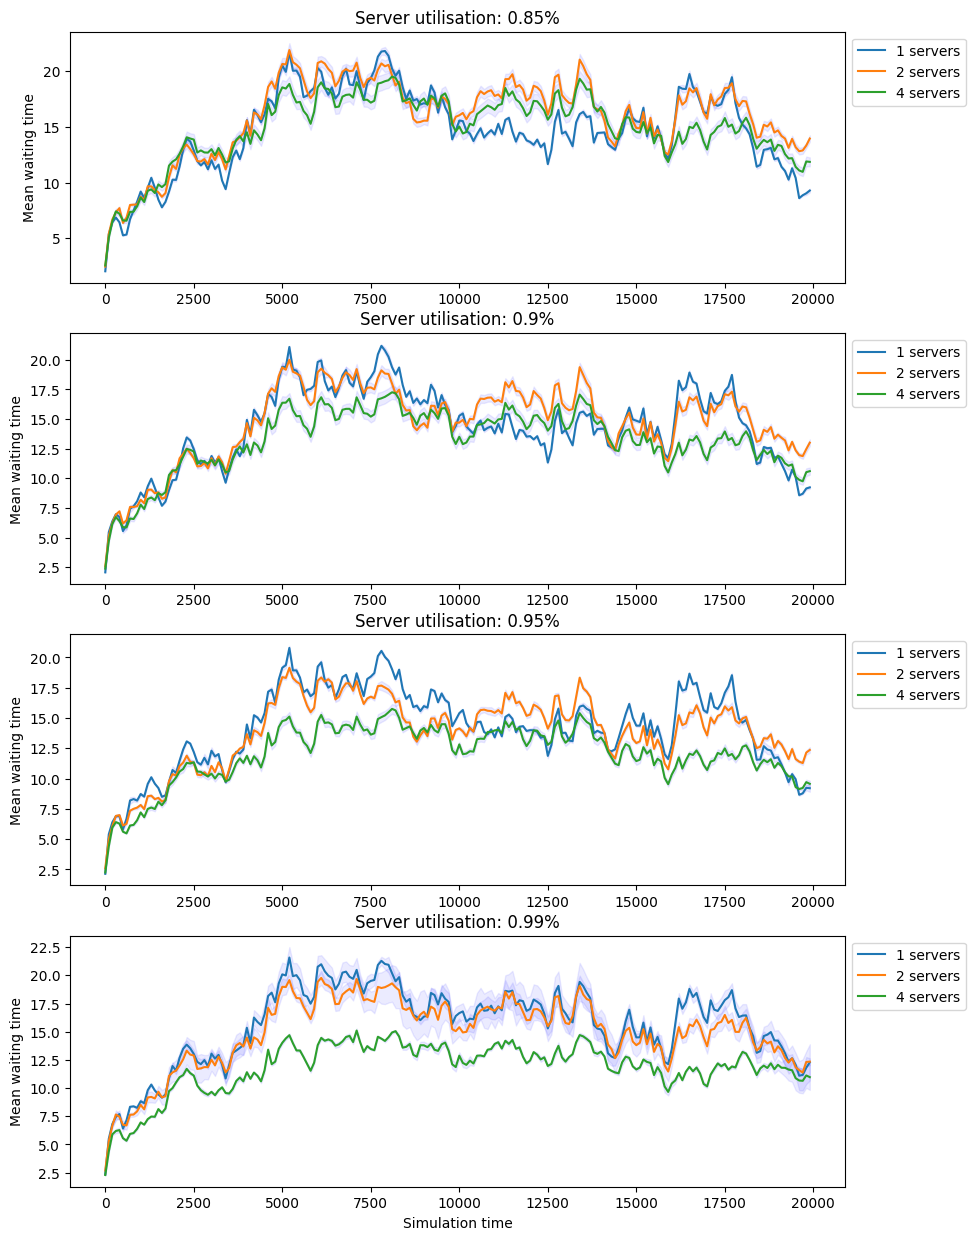

In [48]:
def extract_res_for_plt(dataframe, numb_serv, p_val):
    mask_severs = dataframe["Server_Count"] == numb_serv
    mask_p_value =  dataframe["P_Value"] == p_val
    filted_set = dataframe[mask_severs]
    filted_set_f2 = filted_set[mask_p_value]
    filtered_datasetos = filted_set_f2["Mean_Waiting_time"]
    filtered_datasetos_cl_l = filted_set_f2["CI_Lower_Bound"]
    filtered_datasetos_cl_u = filted_set_f2["CI_Upper_Bound"]
    return filtered_datasetos, filtered_datasetos_cl_l, filtered_datasetos_cl_u


serv = [1, 2, 4]
p = [0.85, 0.9, 0.95, 0.99]


ma = []
for x in range(0, 20000, 100):
    ma.append(x)

fig, axs = plt.subplots(4, 1, figsize=(10, 15)) 
for pp in serv:
    y, low, up = extract_res_for_plt(mean_std_ci_waiting_time, pp, 0.85)
    axs[0].plot(ma, y, label=f"{pp} servers")
    axs[0].fill_between(ma, low, up, color='b', alpha=0.08)
    axs[0].set_ylabel("Mean waiting time")
    #axs[i].legend()
    axs[0].set_title("Server utilisation: 0.85%")
    axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
for pp in serv:
    y, low, up = extract_res_for_plt(mean_std_ci_waiting_time, pp, 0.9)
    axs[1].plot(ma, y, label=f"{pp} servers")
    axs[1].fill_between(ma, low, up, color='b', alpha=0.08)
    axs[1].set_title("Server utilisation: 0.9%")
    axs[1].set_ylabel("Mean waiting time")
    axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
for pp in serv:
    y, low, up = extract_res_for_plt(mean_std_ci_waiting_time, pp, 0.95)
    axs[2].plot(ma, y, label=f"{pp} servers")
    axs[2].fill_between(ma, low, up, color='b', alpha=0.08)
    axs[2].set_ylabel("Mean waiting time")
    axs[2].set_title("Server utilisation: 0.95%")
    axs[2].legend(loc='upper left', bbox_to_anchor=(1, 1))

for pp in serv:
    y, low, up = extract_res_for_plt(mean_std_ci_waiting_time, pp, 0.99)
    axs[3].plot(ma, y, label=f"{pp} servers")
    axs[3].fill_between(ma, low, up, color='b', alpha=0.08)
    axs[3].set_ylabel("Mean waiting time")
    axs[3].set_xlabel("Simulation time")
    axs[3].set_title("Server utilisation: 0.99%")
    axs[3].legend(loc='upper left', bbox_to_anchor=(1, 1))


In [46]:
mean_std_ci_waiting_time

,Server_Count,P_Value,Time_Second,Mean_Waiting_time,Std_Dev_Waiting_time,CI_Lower_Bound,CI_Upper_Bound
0,1.0,0.85,100.0,2.044217,0.012791,2.033005,2.055429
1,1.0,0.85,200.0,5.375865,0.030347,5.349264,5.402465
2,1.0,0.85,300.0,6.434323,0.054727,6.386352,6.482294
3,1.0,0.85,400.0,6.866490,0.083327,6.793451,6.939530
4,1.0,0.85,500.0,6.439471,0.029387,6.413713,6.465229
...,...,...,...,...,...,...,...
2395,4.0,0.99,19600.0,10.878776,1.218799,9.810452,11.947100
2396,4.0,0.99,19700.0,10.676489,1.243828,9.586225,11.766752
2397,4.0,0.99,19800.0,10.648111,1.263476,9.540626,11.755596
2398,4.0,0.99,19900.0,11.124184,1.246424,10.031645,12.216722


In [47]:
waiting_time_general_stat.columns

Index(['Server_Count', 'P_Value', 'Mean_Waiting_time',
       'Mean_Within_Std_of_Waiting_time', 'Customers_Served', 'Mean_queue',
       'Std_within_Waiting_time', 'Std_Dev_Waiting_time',
       'Std_Dev_Customers_served', 'Std_Dev_Queue', 'CI_Lower_Bound_Mean',
       'CI_Upper_Bound_Mean', 'CI_Lower_Bound_Std', 'CI_Upper_Bound_Std',
       'CI_Lower_Bound_Customers_Served', 'CI_Upper_Bound_Customers_Served',
       'CI_Lower_Bound_Queue', 'CI_Upper_Bound_Queue', 'Min_waiting_time',
       'Max_waiting_time', 'Min_queue', 'Max_queue', 'Min_customers_served',
       'Max_customers_served'],
      dtype='object')